In [8]:
# Required imports
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Fetch the dataset
online_retail = fetch_ucirepo(id=352)

# Create full dataframe
X = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)

# Check missing values
print("Missing values per column:", X.isnull().sum())

# Handle missing CustomerID values (important for our customer segmentation)
X_clean = X.dropna(subset=['CustomerID'])

# Basic data cleaning
X_clean = X_clean[X_clean['Quantity'] > 0]  # Remove canceled orders (negative quantities)
X_clean = X_clean[X_clean['UnitPrice'] > 0]  # Valid unit prices

# Convert InvoiceDate to datetime
X_clean['InvoiceDate'] = pd.to_datetime(X_clean['InvoiceDate'])

# Feature engineering for customer behavior
X_clean['TotalPrice'] = X_clean['Quantity'] * X_clean['UnitPrice']

Missing values per column: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [9]:
# Create feature set for classification - RFM Analysis
# Get the latest date to calculate recency
latest_date = X_clean['InvoiceDate'].max()

# Group by CustomerID and calculate RFM metrics (only numerical values)
rfm_numeric = X_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum',  # Monetary Value
    'Quantity': 'mean',  # Average quantity per order
    'UnitPrice': 'mean'  # Average unit price
})

# Rename columns
rfm_numeric.columns = ['Recency', 'Frequency', 'MonetaryValue', 'AvgQuantity', 'AvgUnitPrice']

# Add additional features
# Average transaction value
rfm_numeric['AvgTransactionValue'] = X_clean.groupby('CustomerID')['TotalPrice'].mean()

# Total unique products purchased
rfm_numeric['UniqueProducts'] = X_clean.groupby('CustomerID')['StockCode'].nunique()

# Handle categorical data separately
# Get most frequent country for each customer
country_mode = X_clean.groupby('CustomerID')['Country'].agg(lambda x: x.mode()[0])

# Create a separate categorical dataframe
rfm_categorical = pd.DataFrame(country_mode)

# Now combine our numerical and categorical dataframes
rfm = rfm_numeric.copy()
rfm['Country'] = country_mode

# Create multi-class labels using KMeans clustering for customer segmentation
from sklearn.cluster import KMeans

# Use only numerical features for clustering
rfm_kmeans = rfm_numeric.copy()

# Normalize data for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_kmeans)

# Determine optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Apply KMeans with optimal number of clusters (let's say 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the clusters using only numeric columns
cluster_analysis = rfm_numeric.copy()
cluster_analysis['Cluster'] = rfm['Cluster']
analysis_result = cluster_analysis.groupby('Cluster').mean()
print("Cluster Analysis:\n", analysis_result)

# Define meaningful labels based on cluster characteristics
# This is just an example - adjust based on your actual cluster analysis
cluster_mapping = {
    0: 'High-Value',
    1: 'Medium-Value',
    2: 'Low-Value',
    3: 'One-time'
}

# Map cluster numbers to meaningful labels
rfm['CustomerSegment'] = rfm['Cluster'].map(cluster_mapping)

# Check distribution of segments
print("Customer Segment Distribution:\n", rfm['CustomerSegment'].value_counts())

# Count countries per cluster to understand geographic distribution
country_cluster = pd.crosstab(rfm['Cluster'], rfm['Country'])
print("\nTop countries per cluster:")
for cluster in range(n_clusters):
    top_countries = country_cluster.loc[cluster].nlargest(3)
    print(f"Cluster {cluster} ({cluster_mapping[cluster]}): {top_countries.index.tolist()}")

Cluster Analysis:
             Recency  Frequency  MonetaryValue   AvgQuantity  AvgUnitPrice  \
Cluster                                                                     
0         38.800000   4.867610    1999.550454     18.814619      3.304833   
1          6.000000  79.687500  105050.871250     65.166226      5.184282   
2        162.500000   1.500000  122828.050000  50607.000000      1.350000   
3        239.719298   1.557018     549.445106     29.304570      7.707175   

         AvgTransactionValue  UniqueProducts  
Cluster                                       
0                  29.997736       71.651572  
1                 141.371173      743.625000  
2               66670.550000        2.000000  
3                  57.463732       23.717544  
Customer Segment Distribution:
 CustomerSegment
High-Value      3180
One-time        1140
Medium-Value      16
Low-Value          2
Name: count, dtype: int64

Top countries per cluster:
Cluster 0 (High-Value): ['United Kingdom', 'German

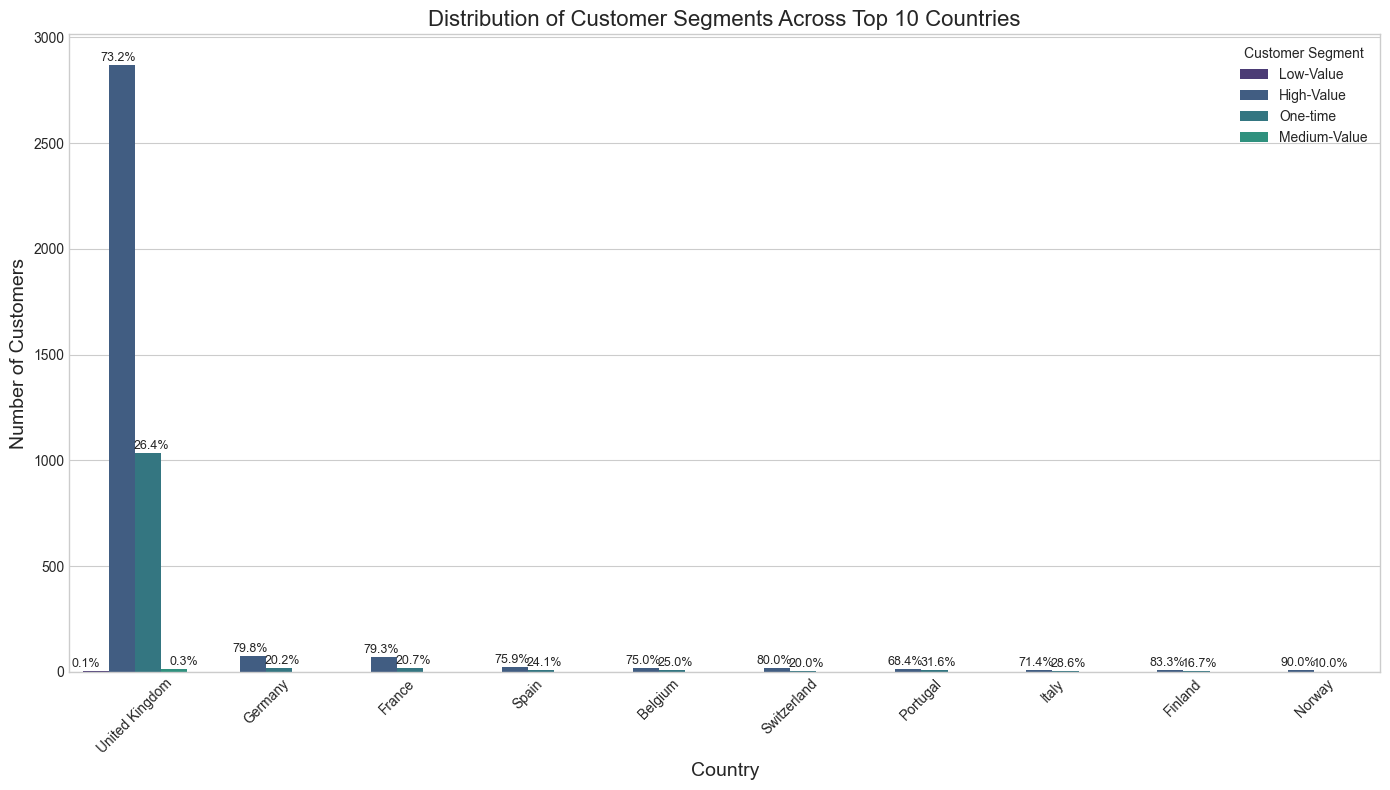

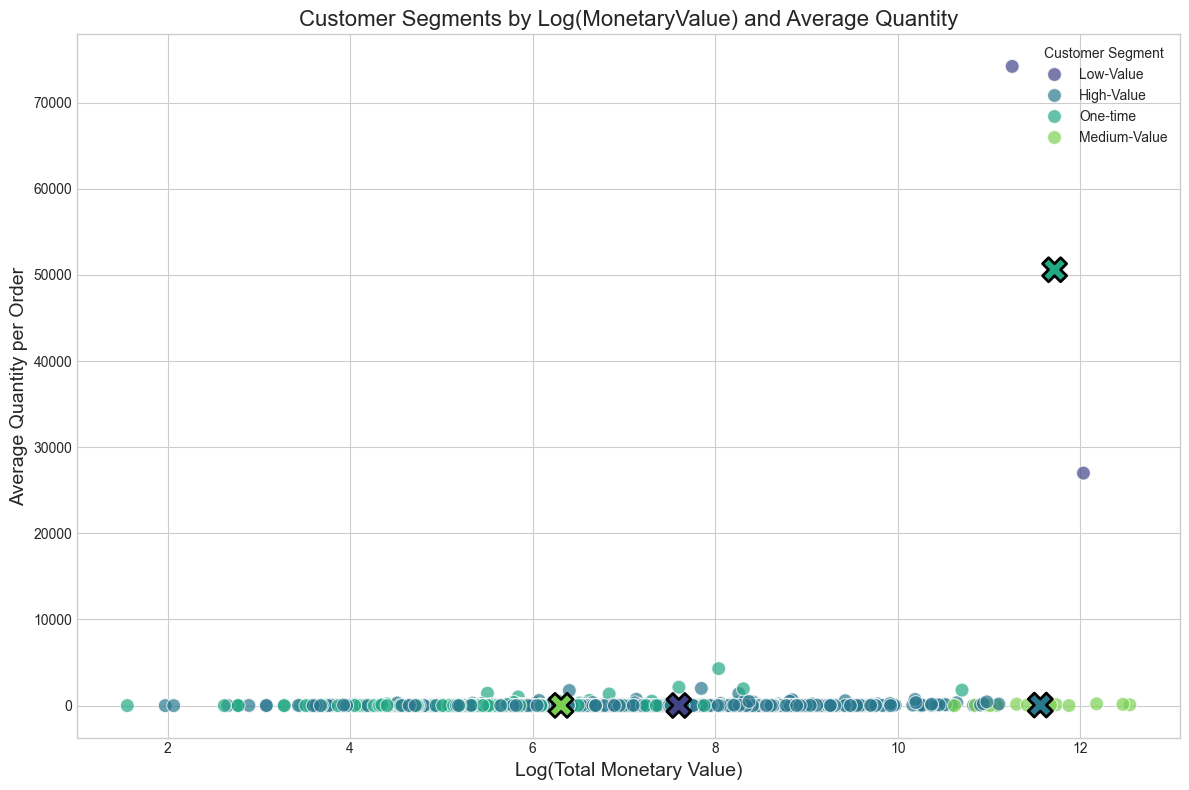

C:\Users\User\AppData\Local\Temp\ipykernel_22924\598339331.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


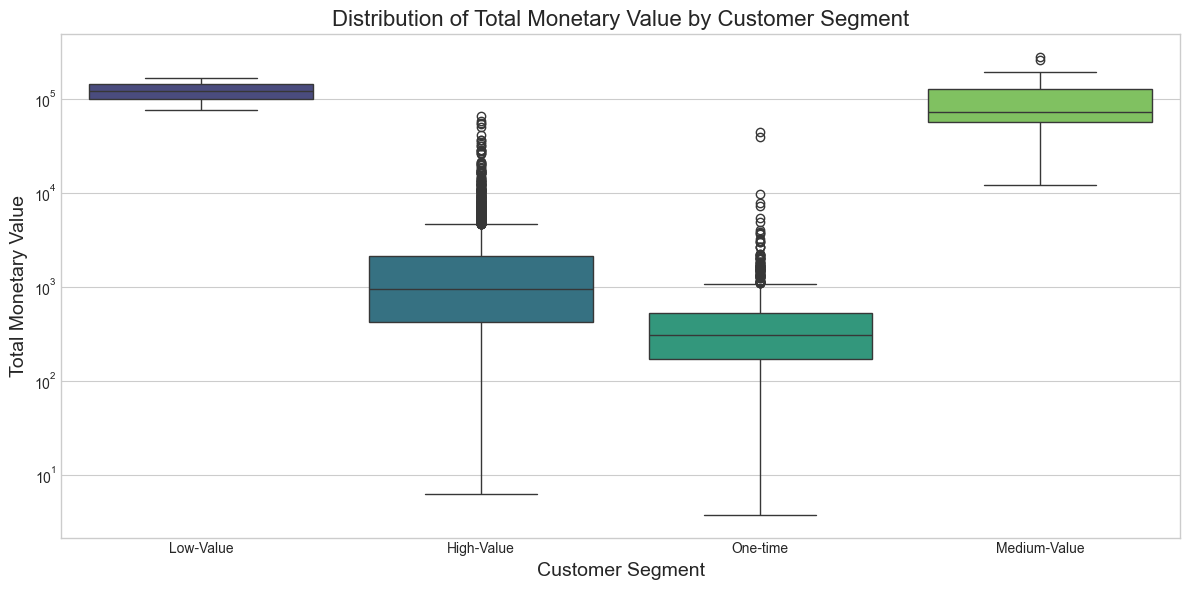

C:\Users\User\AppData\Local\Temp\ipykernel_22924\598339331.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


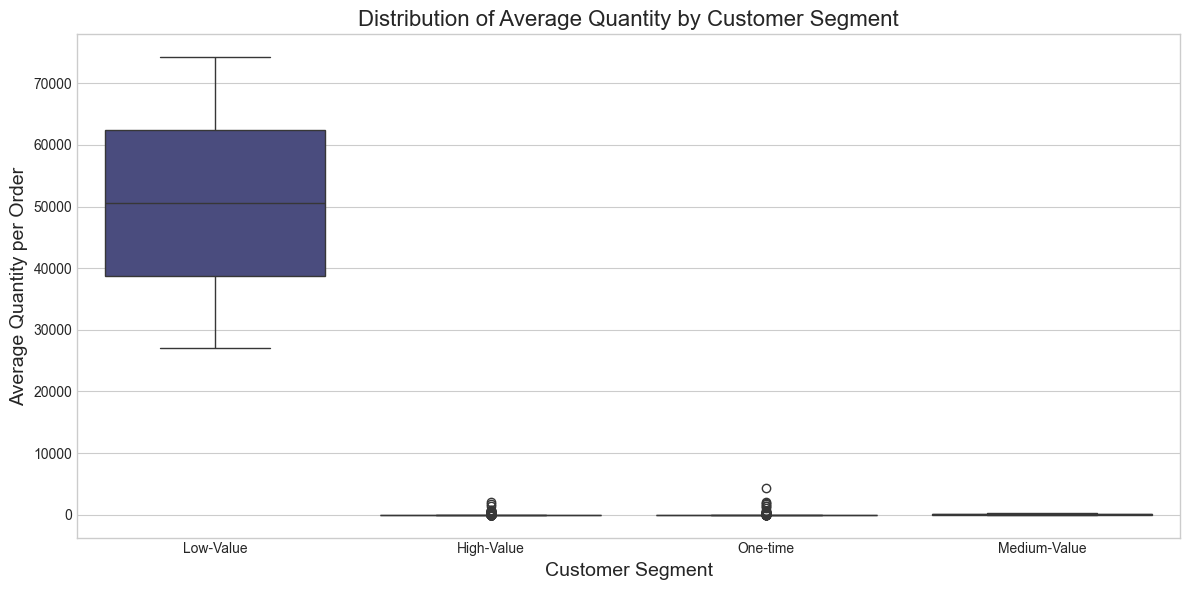

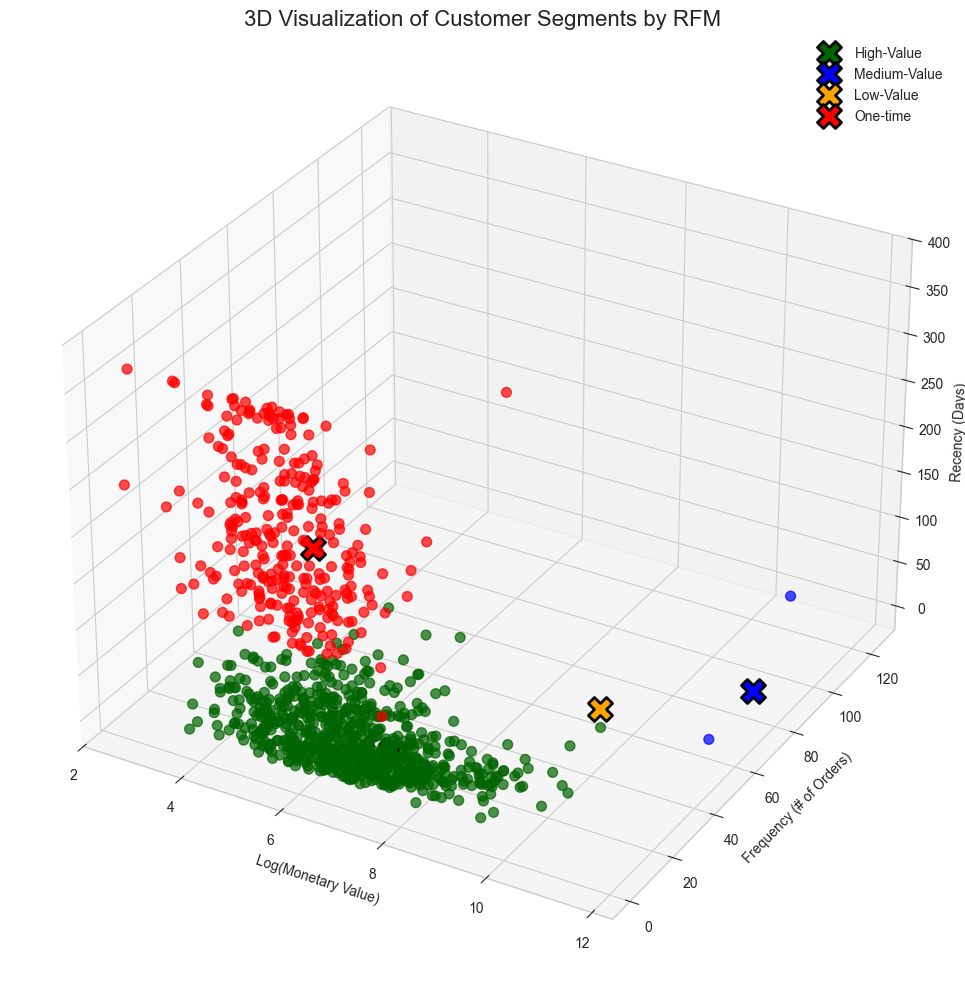

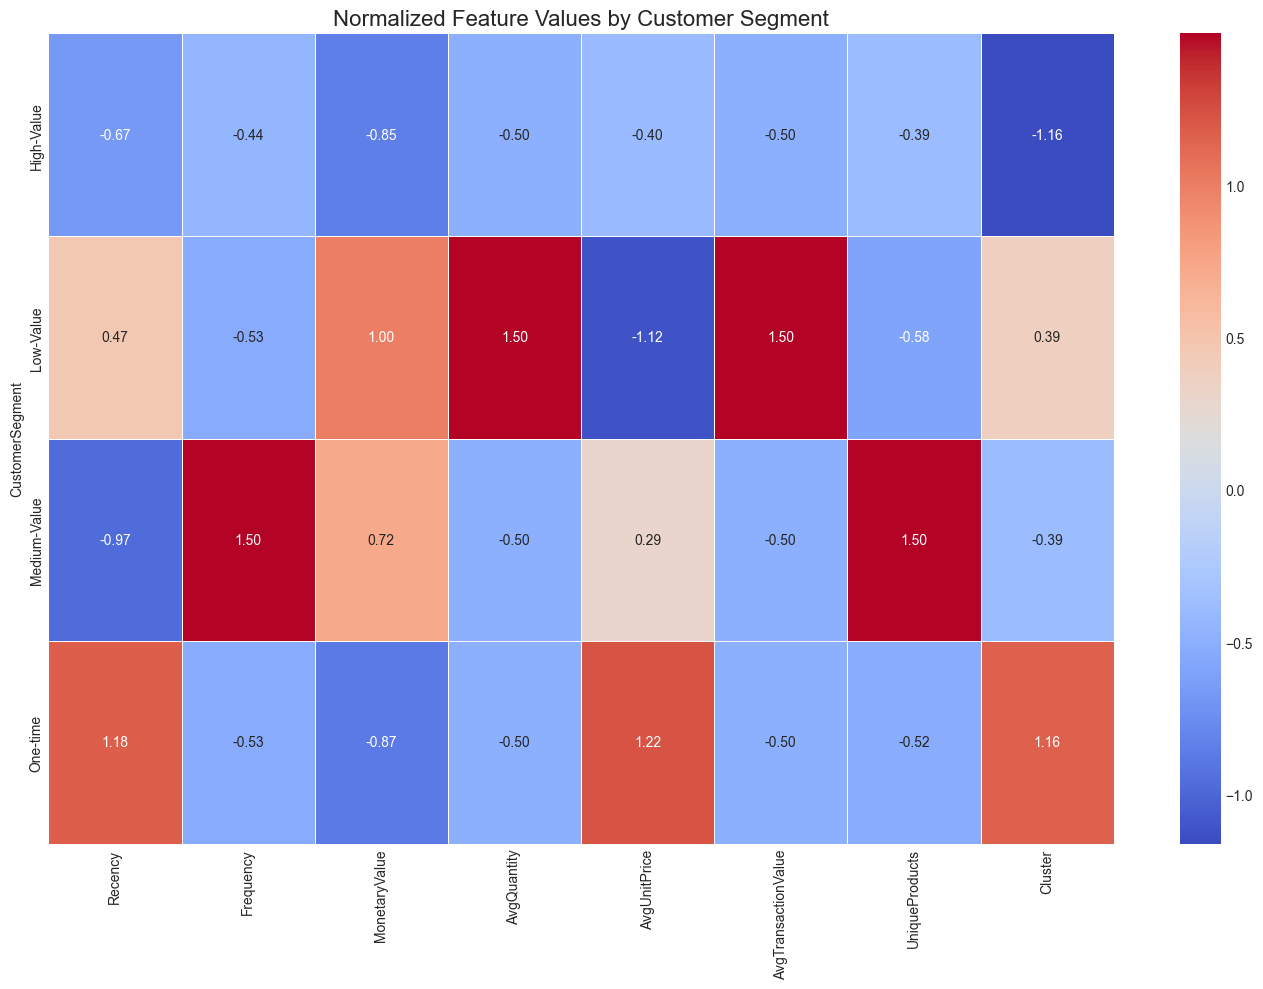

In [13]:
# Set the style for prettier plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# 1. Plot clusters by top countries
# First, get the top 10 countries by frequency
top_countries = rfm['Country'].value_counts().nlargest(10).index

# Filter the data to include only these countries
country_cluster_data = rfm[rfm['Country'].isin(top_countries)]

# Create a count plot
plt.figure(figsize=(14, 8))
ax = sns.countplot(
    data=country_cluster_data,
    x='Country',
    hue='CustomerSegment',
    order=top_countries
)
plt.title('Distribution of Customer Segments Across Top 10 Countries', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Customer Segment')

# Add annotations on top of bars for percentage
totals = country_cluster_data['Country'].value_counts()[top_countries].values
for i, country in enumerate(top_countries):
    for j, segment in enumerate(country_cluster_data['CustomerSegment'].unique()):
        segment_count = len(country_cluster_data[(country_cluster_data['Country'] == country) & 
                                               (country_cluster_data['CustomerSegment'] == segment)])
        if segment_count > 0:  # Only annotate if there are customers in this segment
            percentage = segment_count / totals[i] * 100
            # Find the bar position
            bar_pos = i + (j - 1.5) * 0.25  # Adjust this multiplier based on the number of segments
            ax.text(bar_pos, segment_count + 5, f'{percentage:.1f}%', 
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 2. Scatterplot of MonetaryValue vs. AvgQuantity by cluster
plt.figure(figsize=(12, 8))

# Log scale for monetary value to handle large range
rfm['LogMonetaryValue'] = np.log1p(rfm['MonetaryValue'])

# Create scatter plot
scatter = sns.scatterplot(
    data=rfm,
    x='LogMonetaryValue',
    y='AvgQuantity',
    hue='CustomerSegment',
    palette='viridis',
    alpha=0.7,
    s=100
)

plt.title('Customer Segments by Log(MonetaryValue) and Average Quantity', fontsize=16)
plt.xlabel('Log(Total Monetary Value)', fontsize=14)
plt.ylabel('Average Quantity per Order', fontsize=14)

# Add cluster centroids - Fixed version using concat instead of append
centroids_data = []
for cluster in range(n_clusters):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    centroids_data.append({
        'LogMonetaryValue': np.log1p(cluster_data['MonetaryValue'].mean()),
        'AvgQuantity': cluster_data['AvgQuantity'].mean(),
        'CustomerSegment': cluster_mapping[cluster]
    })

centroids_df = pd.DataFrame(centroids_data)

# Plot centroids
sns.scatterplot(
    data=centroids_df,
    x='LogMonetaryValue',
    y='AvgQuantity',
    hue='CustomerSegment',
    palette='viridis',
    s=300,
    marker='X',
    edgecolor='black',
    linewidth=2,
    legend=False
)

plt.legend(title='Customer Segment')
plt.tight_layout()
plt.show()

# 3. Box plots to show distribution of MonetaryValue by segment
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=rfm,
    x='CustomerSegment',
    y='MonetaryValue',
    palette='viridis'
)
plt.title('Distribution of Total Monetary Value by Customer Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Total Monetary Value', fontsize=14)
plt.yscale('log')  # Log scale to handle outliers
plt.tight_layout()
plt.show()

# 4. Box plots to show distribution of Average Quantity by segment
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=rfm,
    x='CustomerSegment',
    y='AvgQuantity',
    palette='viridis'
)
plt.title('Distribution of Average Quantity by Customer Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Average Quantity per Order', fontsize=14)
plt.tight_layout()
plt.show()

# 5. 3D plot of key RFM dimensions
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create color map
colors = {'High-Value': 'darkgreen', 'Medium-Value': 'blue', 
          'Low-Value': 'orange', 'One-time': 'red'}
color_list = [colors[segment] for segment in rfm['CustomerSegment']]

# Sample a subset of the data to avoid overcrowding (optional)
sample_size = min(1000, len(rfm))
sample_indices = np.random.choice(len(rfm), sample_size, replace=False)
rfm_sample = rfm.iloc[sample_indices]
color_sample = [color_list[i] for i in sample_indices]

# Create the 3D scatter plot
scatter = ax.scatter(
    np.log1p(rfm_sample['MonetaryValue']),
    rfm_sample['Frequency'],
    rfm_sample['Recency'],
    c=color_sample,
    alpha=0.7,
    s=50
)

# Add segment-specific centroids
for segment, color in colors.items():
    segment_data = rfm[rfm['CustomerSegment'] == segment]
    ax.scatter(
        np.log1p(segment_data['MonetaryValue'].mean()),
        segment_data['Frequency'].mean(),
        segment_data['Recency'].mean(),
        c=color,
        s=300,
        marker='X',
        edgecolor='black',
        linewidth=2,
        label=segment
    )

ax.set_xlabel('Log(Monetary Value)')
ax.set_ylabel('Frequency (# of Orders)')
ax.set_zlabel('Recency (Days)')
ax.set_title('3D Visualization of Customer Segments by RFM', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Heatmap of key features by cluster
plt.figure(figsize=(14, 10))

# Prepare cluster profiles data
cluster_profiles = rfm_numeric.join(rfm[['Cluster', 'CustomerSegment']])
cluster_means = cluster_profiles.groupby('CustomerSegment').mean()

# Normalize the values for better visualization
cluster_means_norm = (cluster_means - cluster_means.mean()) / cluster_means.std()

# Create heatmap
sns.heatmap(
    cluster_means_norm,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Normalized Feature Values by Customer Segment', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
# Prepare features and target for classification
X_clf = rfm_numeric.copy()  # Use only numeric features
y_clf = rfm['CustomerSegment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test_scaled)
    
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    
    # Feature importance for tree-based models
    if hasattr(clf, 'feature_importances_'):
        importances = pd.DataFrame({
            'Feature': X_clf.columns,
            'Importance': clf.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{name} Feature Importance:")
        print(importances)

# Hyperparameter tuning for the best model (e.g., Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted'
)

grid_search.fit(X_train_scaled, y_train)
print("\nBest Parameters:", grid_search.best_params_)

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred))


Training Random Forest...
Random Forest Performance:
Accuracy: 0.9880
Classification Report:
              precision    recall  f1-score   support

  High-Value       0.99      0.99      0.99       787
Medium-Value       1.00      0.67      0.80         6
    One-time       0.97      0.99      0.98       292

    accuracy                           0.99      1085
   macro avg       0.99      0.88      0.92      1085
weighted avg       0.99      0.99      0.99      1085


Random Forest Feature Importance:
               Feature  Importance
0              Recency    0.784514
1            Frequency    0.072197
2        MonetaryValue    0.056025
6       UniqueProducts    0.038698
4         AvgUnitPrice    0.020952
3          AvgQuantity    0.013877
5  AvgTransactionValue    0.013736

Training Gradient Boosting...
Gradient Boosting Performance:
Accuracy: 0.9917
Classification Report:
              precision    recall  f1-score   support

  High-Value       0.99      0.99      0.99       787

c:\Users\User\x-med\.conda\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

Tuned Model Performance:
              precision    recall  f1-score   support

  High-Value       1.00      0.99      0.99       787
Medium-Value       1.00      1.00      1.00         6
    One-time       0.98      0.99      0.98       292

    accuracy                           0.99      1085
   macro avg       0.99      0.99      0.99      1085
weighted avg       0.99      0.99      0.99      1085

